## BAYESIAN CLASSIFICATION using MULTIVARIATE GAUSSIAN MIXTURE MODELS
### CASE STUDY: Recognize VOWELS from FORMANTS


#### Reading Material
We make use of the Hillenbrand database.   The Hillebrand database contains average formant values measured over vowels.
For scatter plots and data exploration we refer to notebook ../lab03/FormantDistribution.ipynb or its corresponding output 
[FormantDistribution](https://compi1234.github.io/spchlab/Tutorials/FormantDistribution.html) 

#### Methods
We perform vowel classification based on a single observation (average formant values) as provided by the Hillenbrand database.
We use statistical machine learning techniques based on data modeling and Bayesian inference.
We will model 1D or multi-D formant data using Gaussian distributions or mixtures of Gaussians (GMMs).


### 1. Setting up your Python Environment

In [10]:
####################################################################################
### This setting is to avoid memory leaks in sklearn KMEANS on windows+MKL machines 
### This must be executed before importing numpy (here or in other packages) 
import os
os.environ["OMP_NUM_THREADS"] = '2'  
import warnings
warnings.filterwarnings("ignore")
####################################################################################

In [11]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
# Importing Python's baseline machine learning stack 
#
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.io as sio

# imports from the scikit-learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

import pyspch.core as Spch
from pyspch.stats import GMM
from pyspch.core.hillenbrand import fetch_hillenbrand, select_hillenbrand

import pyspch.display as Spd   # sets some plotting preferences
colors = Spd.colors
markers = Spd.markers
cmap = sns.color_palette(colors)
sns.set_palette(cmap)
np.set_printoptions(precision=2)
#
# making a color - phoneme mapping and defining vowel subsets
vowel_order = ['iy','aa','uw','ih','eh','er','ah','ae','ao','uh','ey','ow']
vowel2color = dict(zip(vowel_order,colors))
color2vowel = dict(zip(colors,vowel_order))
vow12 = vowel_order
vow10 = vowel_order[0:10]
vow6 = vowel_order[0:6]
vow3 = vowel_order[0:3]

### 2. The Database 
All experiments in this notebook are using (parts of) the Hillenbrand '95 database. For detailed information and references: https://homes.esat.kuleuven.be/~spchlab/datasets/hillenbrand/README.txt

We grab only a selection of the database with the principle measurements that can be used to do vowel recognition from psychoacoustic measurements (3 formants, pitch, duration).  
We drop all records with missing data.

In [4]:
hildata = fetch_hillenbrand(columns=["gender","vowel","dur","f0","F1","F2","F3"],symbols="arpa").dropna()
print(hildata.head())

      gender vowel    dur     f0     F1      F2      F3
fid                                                    
m01ae      m    ae  323.0  174.0  663.0  2012.0  2659.0
m02ae      m    ae  250.0  102.0  628.0  1871.0  2477.0
m03ae      m    ae  344.0   99.0  605.0  1812.0  2570.0
m04ae      m    ae  312.0  124.0  627.0  1910.0  2488.0
m06ae      m    ae  254.0  115.0  647.0  1864.0  2561.0


### 3. Data Exploration

In this task we first explore if the five features (dur, f0, F1, F2 and F3) make sense and if we expect them to contribute all to a vowel classification task.

Scatter plots may give us an insight as to which features are most relevant.
We can either make 
+ a simple scatter plot with 2 preselected features (F1 and F2 are preselected in the next cell, but you can fill in other features), 
+ or we can make a gridplot containing a collection of scatter plots for a better overall view

#### Tasks & Questions (1)
1. What do the scatter plots tell you.  Are there features that must be retained or others that can surely be dropped ?
2. Try to rank the features in order of importance for this 12 vowel classification task

<Axes: xlabel='F1', ylabel='F2'>

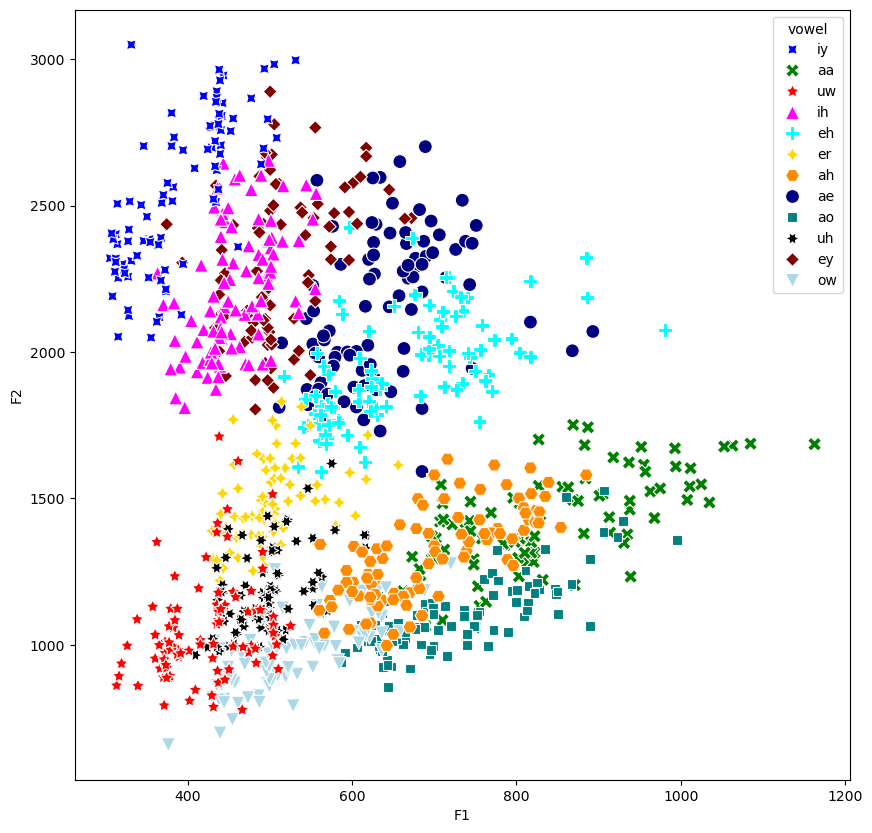

In [5]:
# a simple scatter plot with 2 selected features
# the categgories can be shown as hue(color) or style(marker)
# data is limited to the adult data
f=plt.figure() 
data = select_hillenbrand(hildata,genders='adults',vowels=vow12)
sns.scatterplot(x='F1',y='F2',data=data,hue="vowel",style="vowel",hue_order=vowel_order,s=100)

<Figure size 1000x1000 with 0 Axes>

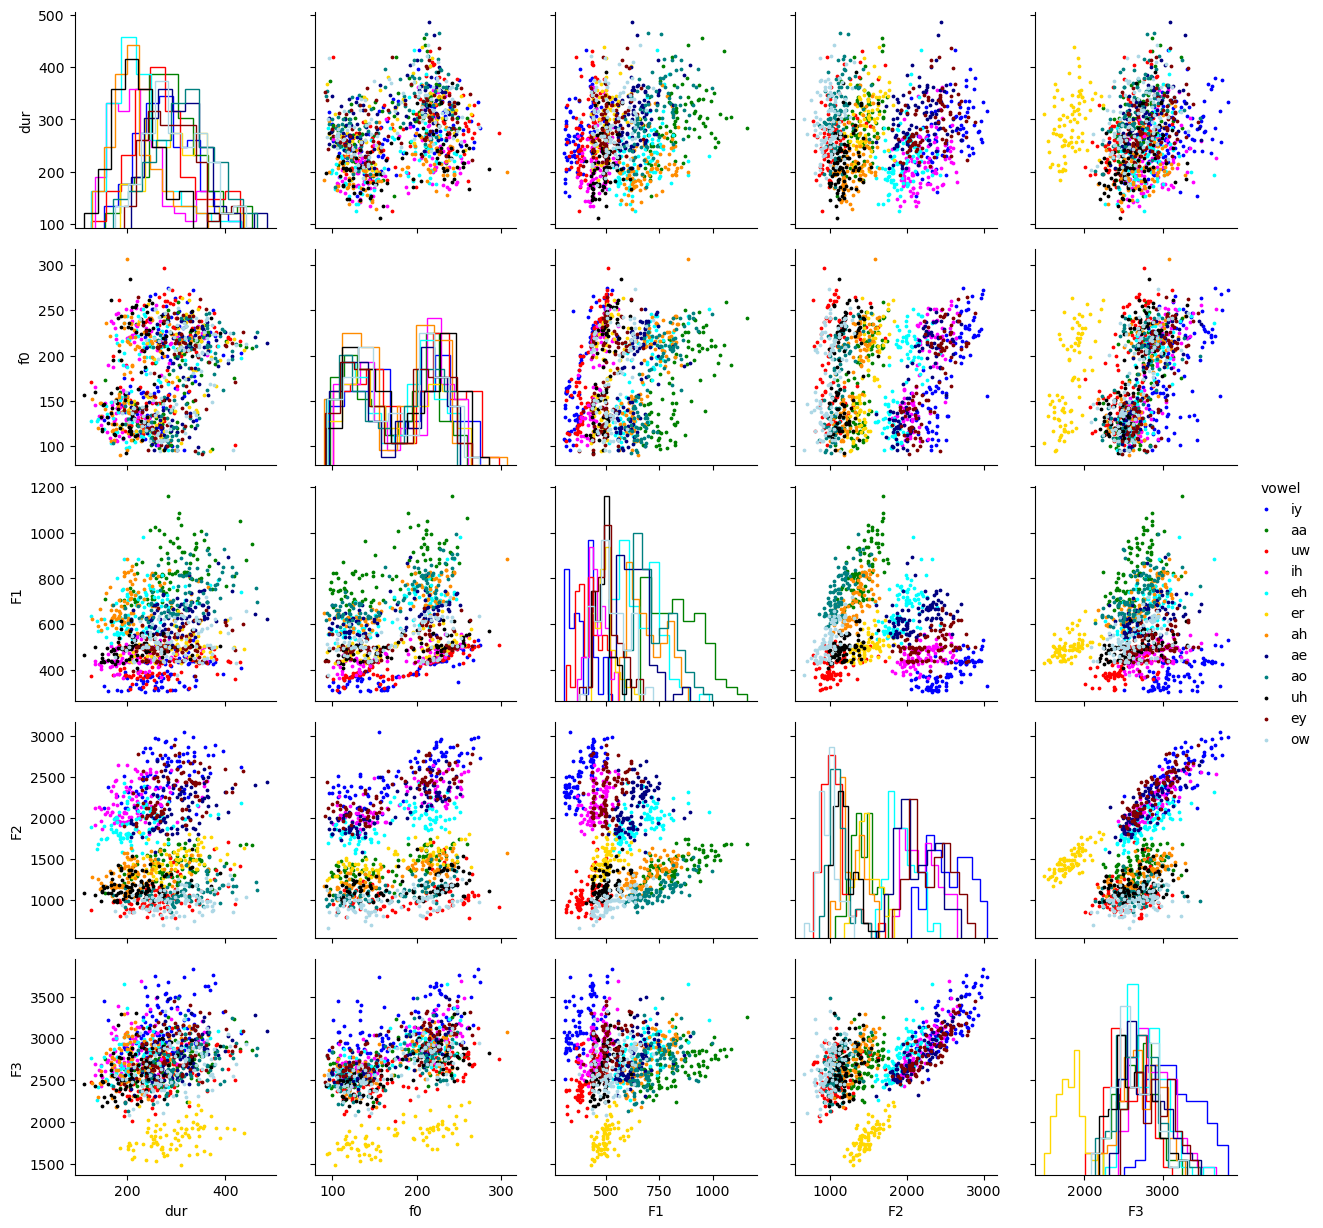

In [6]:
f=plt.figure()
g = sns.PairGrid(data,hue="vowel",hue_order=vow12)
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=3)
g.add_legend()

### 4. Classification using a Bayesian classifier and Gaussian Mixture Models

First we select the subset of the Hillenbrand database that we want to do our experiments on.
We can choose a subset of genders (e.g. ['m','w'] for the adults or ['b','g'] for the children).
Furthermore we can limit the number of vowels to be considered.  The default is 'vow10', which corresponds to the 10
vowels included in the Peterson Barney database.  If you want simpler tasks, use the predefined vow6 or vow3 defintions of vowel subsets.


Performing a recognition experiments consist of following steps
1. split the data in  training set and  test set
    -  X_train, y_train, X_test, y_test
2. train models in each class given the training data 
3. construct a classifier using the Bayesian rule and posteriors
4. evaluate on test data; look at overall score 
5. look more in detail to a confusion matrix (next codeblock)

##### Implementation:   
We use the class *GMM* which is provided in the pyspch.stats package.
Its user interface is similar to all classifiers in *sklearn*, the GMM contains for each
class a GaussianMixture density estimator.  
During inference the likelihoods are combined with the estimated (or predefined) priors to compute the class posteriors

There are a number of parameters that you may adjust in the following code blocks
- n_components:  the number of mixtures used in the Gaussian MM
- train_size:    the proportion of the data that will be used for training, the remainder is used for testing
- priors_test:   you can override the class priors during testing
- random_state:  this number controls the random division between train and test set. You can modify this to see if different divisions lead to different results


##### Task & Questions (2)
1. Evaluate the performance for different settings in n_components (number of gaussians) 1,2,4,8 . Is there a need to change max_iter, the maximum number of iterations for EM
2. Evaluate the performance for different feature sets, [F1,F2] vs. [F1,F2,F3]
3. (optional) Go back and use a smaller database, just selecting the short vowels with 'vowels6' and do the same analysis
4. (optional) Go back and add 'dur' as a 4th feature.  Duration is temporal feature and could be complementary to the formants that are spectral features.  Where in the confusion matrix could you hope for an improvement ? 

In [7]:
# make a subselection of the data for your experiment
# -- on vowels 
#
# In this notebook we always use a single formant measure per recording which
# is obtained from a 'mid-vowel' measurement.   This is a poor characterizations
# for the diphtongs 'ey' and 'ow' in the list.
# Therefore we recommend just using the 'vow10' selection (basically the Peterson Barney list)
# or use more discriminable subsets 'vow6' or 'vow3'
# 
# All of the above is achieved by specifying the correct list in 'vowel_selection'
#
# -- on speakers
#
# By default a gender_selection to 'adults' is specified which is equivalent to ['m','w']
#    other possibilities are any list of ['m','w','b','g'] 
vowel_selection = vow10
gender_selection = ['m','w'] # 'adults'
data = select_hillenbrand(hildata,genders=gender_selection,vowels=vowel_selection)

# --------------
# select the features to be used as observations, one or several of ['F1','F2','F3','dur']
# and set a number of parameters for the GMM modeling training 
# -- most relevant at this point: n_components, i.e. the number of mixtures
feature_list = ['F1','F2','F3']
X=np.array(data.loc[:,feature_list])
y=np.array(data.loc[:,'vowel'])
classes = vowel_selection
n_components = 4
train_size=0.5
max_iter = 10      # maximum number of iterations in the EM algorithm
random_state = 0
priors_test = None # should be None or a vector of type e.g. [0.8 , 0.2] expects 80% male
# --------------
# 1. select non-overlapping train and test sets
test_size=1.0 - train_size
X_train, X_test, y_train, y_test =  train_test_split(X[:,0:3],y,test_size=test_size, random_state=random_state)
clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=max_iter)
clf_GMM.fit(X_train,y_train)
# 2. print the model
clf_GMM.print_model()
y_pred = clf_GMM.predict(X_test,priors=priors_test)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

Class[0] (iy) with prior=0.108
-----------------------------------
0.06430266247699278 [ 344.9  2408.5  3437.99] [  171.37 51803.57  3068.64]
0.41130192164522933 [ 344.41 2272.27 2935.69] [  711.21  5946.21 27531.36]
0.3522561192035835 [ 432.72 2709.17 3272.1 ] [ 1259.86 14175.34 29131.41]
0.17213929667419442 [ 470.34 2893.78 3655.44] [ 1454.27 10120.46 12157.24]

Class[1] (aa) with prior=0.115
-----------------------------------
0.4031435528618239 [ 739.26 1345.61 2494.85] [2364.39 6312.68 8217.33]
0.2072660009286449 [ 823.99 1290.65 2693.34] [ 4285.43 14820.32  7581.95]
0.2845527542402465 [ 911.77 1529.88 2815.62] [ 4358.09  5842.56 12994.33]
0.10503769196928468 [1014.2  1664.91 2892.53] [11118.11  3258.28 43712.38]

Class[2] (uw) with prior=0.101
-----------------------------------
0.23297950083068233 [ 483.29 1068.03 2661.54] [  296.79 22880.2   6352.26]
0.47606460174333853 [ 376.03  966.54 2357.09] [ 1092.66  7693.46 13606.06]
0.20445526115077386 [ 447.03 1035.96 2824.95] [ 2918.4

C:\Users\compi\miniforge3\envs\py310t\lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\compi\miniforge3\envs\py310t\lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\compi\miniforge3\envs\py310t\lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\compi\miniforge3\envs\py310t\lib\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\compi\minif

Global Accuracy: 77.14%


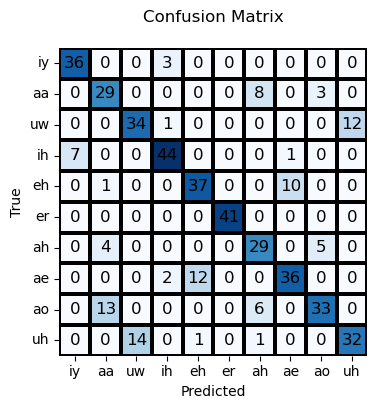

(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': 'Confusion Matrix\n'}, xlabel='Predicted', ylabel='True'>)

In [8]:
#
# A Confusion Matrix gives a more detailed image of the errors that we make
y_pred = clf_GMM.predict(X_test)
cf_mat = skmetrics.confusion_matrix(y_test,y_pred,labels=classes)    
print('Global Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))
Spch.plot_confusion_matrix(cf_mat,labels=classes)

#### Task & Questions (3)
Given this rather limited database, we may prefer a cross_validation style evaluation

1. Evaluate the performance for different settings in n_components (number of gaussians) 1,2,4,8 . Is there a need to change max_iter, the maximum number of iterations for EM
2. Evaluate the performance for different feature sets, [F1,F2] vs. [F1,F2,F3]
   use X for all features X[:,0:2] for features F1 and F2  or X[:,i] for a single feature with i for feature 0..2  or also [:,[0,1,3]] for a combination of F1,F2 and duration 
3. Change the number of folds in the crossvalidation between 2, 5 and 10.  Is there a trend in the
recognition scores ?  Is this to be expected and what does it tell you about the size of the database ?
4. (optional) Go back and use a smaller (easier) database, just selecting the short vowels with 'vow6' and do the same analysis


In [9]:
n_components = 1
nfold_options = [4] # [5,10,2]
ftr_options = [ ['F1','F2','F3'], ['F1','F2'], ['F2','F3'], ['F2'] , ['F1']]
for ftrs in ftr_options:
    print('Features: ',ftrs)
    X=np.array(data.loc[:,ftrs])
    clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=20)
    for nfolds in nfold_options:
        scores = cross_val_score(clf_GMM, X, y, cv=nfolds)
        print("Average Cross validation score for %d folds: %.2f %% correct" % (nfolds,100.0*np.average(scores)))

Features:  ['F1', 'F2', 'F3']
Average Cross validation score for 4 folds: 68.32 % correct
Features:  ['F1', 'F2']
Average Cross validation score for 4 folds: 64.36 % correct
Features:  ['F2', 'F3']
Average Cross validation score for 4 folds: 40.49 % correct
Features:  ['F2']
Average Cross validation score for 4 folds: 32.68 % correct
Features:  ['F1']
Average Cross validation score for 4 folds: 28.83 % correct
